In [1]:
# ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/AR3/variation/crosses/ar3/hdf5/ag1000g.crosses.phase1.ar3sites.3L.h5
# ftp://ngs.sanger.ac.uk/production/ag1000g/phase1/AR3/variation/crosses/ar3/hdf5/ag1000g.crosses.phase1.ar3sites.3R.h5


In [2]:
import random

import matplotlib.pyplot as plt
import h5py
import pandas as pd

%matplotlib inline

In [3]:
num_sims = 100000
num_ofs = 20

1


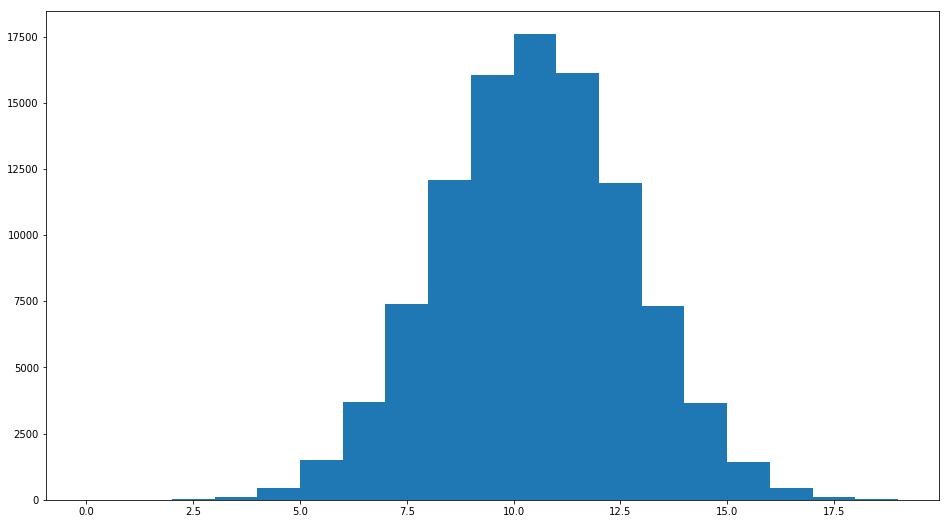

In [4]:
num_hets_AA_AT = []
for sim in range(num_sims):
    sim_hets = 0
    for ofs in range(20):
        sim_hets += 1 if random.choice([0, 1]) == 1 else 0
    num_hets_AA_AT.append(sim_hets)
    
fig, ax = plt.subplots(1,1, figsize=(16,9))
ax.hist(num_hets_AA_AT, bins=range(20))
print(len([num_hets for num_hets in num_hets_AA_AT if num_hets==20]))

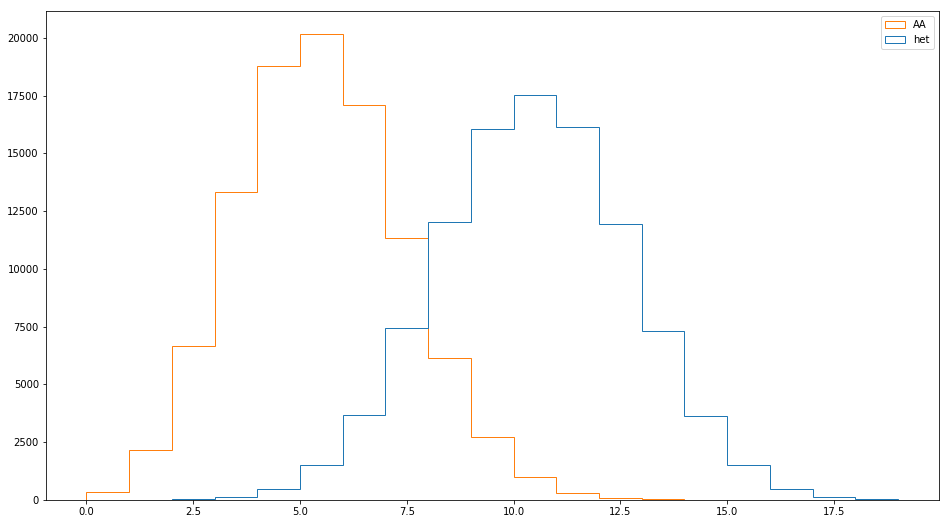

In [5]:
num_AAs_AT_AT = []
num_hets_AT_AT = []
for sim in range(num_sims):
    sim_AAs = 0
    sim_hets = 0
    for ofs in range(20):
        derived_cnt = sum(random.choices([0, 1], k=2))
        sim_AAs += 1 if derived_cnt == 0 else 0
        sim_hets += 1 if derived_cnt == 1 else 0
    num_AAs_AT_AT.append(sim_AAs)
    num_hets_AT_AT.append(sim_hets)
fig, ax = plt.subplots(1,1, figsize=(16,9))
ax.hist([num_hets_AT_AT, num_AAs_AT_AT], histtype='step', fill=False, bins=range(20), label=['het', 'AA'])
plt.legend()

In [6]:
h5_3L = h5py.File('ag1000g.crosses.phase1.ar3sites.3L.h5', 'r')
samples = h5_3L['/3L/samples']

print(list(samples))

[b'AD0231-C', b'AD0232-C', b'AD0234-C', b'AD0235-C', b'AD0236-C', b'AD0237-C', b'AD0238-C', b'AD0239-C', b'AD0240-C', b'AD0241-C', b'AD0242-C', b'AD0243-C', b'AD0244-C', b'AD0245-C', b'AD0246-C', b'AD0247-C', b'AD0248-C', b'AD0249-C', b'AD0250-C', b'AD0251-C', b'AD0252-C', b'AD0253-C', b'AD0254-C', b'AD0255-C', b'AD0259-C', b'AD0260-C', b'AD0261-C', b'AD0262-C', b'AD0263-C', b'AD0265-C', b'AD0266-C', b'AD0267-C', b'AD0268-C', b'AD0269-C', b'AD0270-C', b'AD0271-C', b'AD0272-C', b'AD0273-C', b'AD0274-C', b'AD0275-C', b'AD0276-C', b'AD0305-C', b'AD0306-C', b'AD0309-C', b'AD0310-C', b'AD0311-C', b'AD0312-C', b'AD0313-C', b'AD0314-C', b'AD0315-C', b'AD0316-C', b'AD0317-C', b'AD0318-C', b'AD0319-C', b'AD0320-C', b'AD0322-C', b'AD0323-C', b'AD0347-C', b'AD0348-C', b'AD0351-C', b'AD0352-C', b'AD0353-C', b'AD0354-C', b'AD0355-C', b'AD0356-C', b'AD0357-C', b'AD0358-C', b'AD0359-C', b'AD0360-C', b'AD0361-C', b'AD0362-C', b'AD0363-C', b'AD0364-C', b'AD0365-C', b'AD0366-C', b'AD0367-C', b'AD0368-C'

In [7]:
samples = pd.read_csv('samples.tsv', sep='\t')
print(samples['cross'].unique())
print(samples[samples['cross'] == 'cross-29-2'][['id', 'function']])
print(len(samples[samples['cross'] == 'cross-29-2']))

['cross-29-2' 'cross-36-9' 'cross-42-4' 'cross-46-9']
          id function
0   AD0231-C   parent
1   AD0232-C   parent
2   AD0234-C  progeny
3   AD0235-C  progeny
4   AD0236-C  progeny
5   AD0237-C  progeny
6   AD0238-C  progeny
7   AD0239-C  progeny
8   AD0240-C  progeny
9   AD0241-C  progeny
10  AD0242-C  progeny
11  AD0243-C  progeny
12  AD0244-C  progeny
13  AD0245-C  progeny
14  AD0246-C  progeny
15  AD0247-C  progeny
16  AD0248-C  progeny
17  AD0249-C  progeny
18  AD0250-C  progeny
19  AD0251-C  progeny
20  AD0252-C  progeny
21  AD0253-C  progeny
22


In [8]:
calldata_genotype = h5_3L['/3L/calldata/genotype']
positions = h5_3L['/3L/variants/POS']
alt_alleles = h5_3L['/3L/variants/ALT']
is_snp = h5_3L['/3L/variants/is_snp']
#QD MQ0 QUAL FS DP HRun ReadPosRankSum